### Fetch HydroViz data from Geoserver / Rasdaman*

This notebook demonstrates how to fetch the SECASC HydroViz vector data (stream segments and watersheds) from Geoserver using a HUC6 polygon. 

The geometry attributes are then used to query streamflow statistics data from Rasdaman (*coming soon!)

In [70]:
import requests
import io
import xarray as xr
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from luts import encodings_lookup

# set parameters using dev version of Geoserver
base_url = "https://gs.earthmaps.io/geoserver/"
dir = "hydrology"
layers = ["seg", "hru"]
output = "application/json"
wfs_get_string = "/ows?service=WFS&version=1.0.0&request=GetFeature&typeName="

# load HUC6 polygons and transform to match project CRS: EPSG:5070 (NAD83 / Conus Albers)
# in this future, this data could also be hosted on Geoserver and accessed via WFS
# chinook
# huc6 = gpd.read_file('/import/beegfs/CMIP6/jdpaul3/hydroviz_data/export/WBDHU6.shp').to_crs('EPSG:5070')
# local
huc6 = gpd.read_file("/Users/joshpaul/secasc_hydroviz/other_gis/HUC/WBDHU6.shp").to_crs(
    "EPSG:5070"
)

In [71]:
# we will build a function that uses a single polygon to define the bounding box request


def get_bbox_features_and_clip(base_request_string, polygon_gdf):
    # validate geometry
    polygon_gdf["geometry"] = polygon_gdf["geometry"].make_valid()

    # get the bounds of the polygon - expects a gdf with single polygon, return error if not
    if len(polygon_gdf) > 1:
        print(
            "Input polygon gdf has more than one polygon. Please provide a gdf with only one polygon."
        )
        return None  # in the API, return a specific error
    else:
        xmin, ymin, xmax, ymax = polygon_gdf.bounds.values[0]

        # build the bbox string, double checking that the xmin/xmax values are in the correct order
        # this is somewhat redundant but when the projected coordinates are negative, the order can be flipped and produce errors
        bbox_string = (
            str(int(min(xmin, xmax)))
            + ", "
            + str(int(min(ymin, ymax)))
            + ", "
            + str(int(max(xmin, xmax)))
            + ", "
            + str(int(max(ymin, ymax)))
        )

        # create the bbox request string
        bbox_request_string = base_request_string + "&bbox=" + bbox_string

        # also tried this with a CQL filter..."the_geom" is the default geometry field in Geoserver
        # cql_bbox_request_string = base_request_string + "&cql_filter=bbox(the_geom," + bbox_string + ")"

        print(
            f"Fetching data for {polygon_gdf.name.loc[0]} (HUC6: {polygon_gdf.huc6.loc[0]}) using bbox: {bbox_string}"
        )
        print(f"Request URL: {bbox_request_string}")

        # get the features
        with requests.get(
            bbox_request_string, verify=False
        ) as r:  # verify=False is necessary for dev version of Geoserver
            if r.status_code != 200:
                print(
                    "No response from server. Please check the request string and try again."
                )
                return None  # in the API, return a specific error
            else:
                try:
                    r_json = r.json()
                except:
                    print("Unable to decode as JSON. Returning raw text:\n", r.text)
                    return r.text

        # create a valid geodataframe from the features and clip the features to the polygon
        bbox_gdf = gpd.GeoDataFrame.from_features(r_json["features"], crs="EPSG:5070")
        bbox_gdf["geometry"] = bbox_gdf["geometry"].make_valid()

        clipped_gdf = gpd.clip(bbox_gdf, polygon_gdf)

        return clipped_gdf

<Axes: >

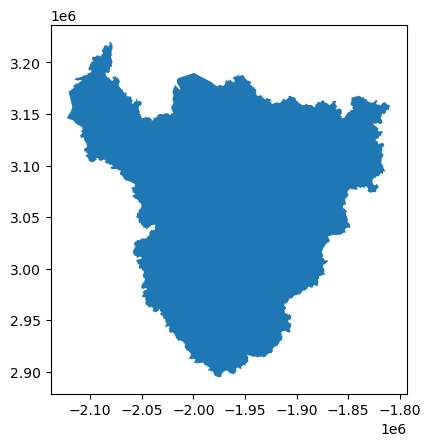

In [72]:
# let's test by using the HUC6 for Puget Sound
# here we search by name, but could also search by ID
huc6_name = "Puget Sound"

puget_huc6 = huc6[huc6["name"] == huc6_name][["name", "huc6", "geometry"]].reset_index(
    drop=True
)

huc6_id = puget_huc6.huc6.loc[0]

puget_huc6.plot()

In [73]:
# and build basic feature request strings for the two geometries
# these would get all the features, but that request would definitely fail due to the size of the file!

request_strings = [
    base_url + dir + wfs_get_string + dir + ":" + layers[0] + "&outputFormat=" + output,
    base_url + dir + wfs_get_string + dir + ":" + layers[1] + "&outputFormat=" + output,
]

print(request_strings[0])
print(request_strings[1])

https://gs.earthmaps.io/geoserver/hydrology/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=hydrology:seg&outputFormat=application/json
https://gs.earthmaps.io/geoserver/hydrology/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=hydrology:hru&outputFormat=application/json


In [74]:
# get the features
puget_segments = get_bbox_features_and_clip(request_strings[0], puget_huc6)
puget_watersheds = get_bbox_features_and_clip(request_strings[1], puget_huc6)

Fetching data for Puget Sound (HUC6: 171100) using bbox: -2122635, 2894750, -1809114, 3220385
Request URL: https://gs.earthmaps.io/geoserver/hydrology/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=hydrology:seg&outputFormat=application/json&bbox=-2122635, 2894750, -1809114, 3220385


/Users/joshpaul/miniconda3/envs/snap-geo/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gs.earthmaps.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/joshpaul/miniconda3/envs/snap-geo/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/joshpaul/miniconda3/envs/snap-geo/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gs.earthmaps.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Fetching data for Puget Sound (HUC6: 171100) using bbox: -2122635, 2894750, -1809114, 3220385
Request URL: https://gs.earthmaps.io/geoserver/hydrology/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=hydrology:hru&outputFormat=application/json&bbox=-2122635, 2894750, -1809114, 3220385


/Users/joshpaul/miniconda3/envs/snap-geo/lib/python3.11/site-packages/shapely/constructive.py:542: RuntimeWarning: invalid value encountered in make_valid
  return lib.make_valid(geometry, **kwargs)
/Users/joshpaul/miniconda3/envs/snap-geo/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


<Axes: >

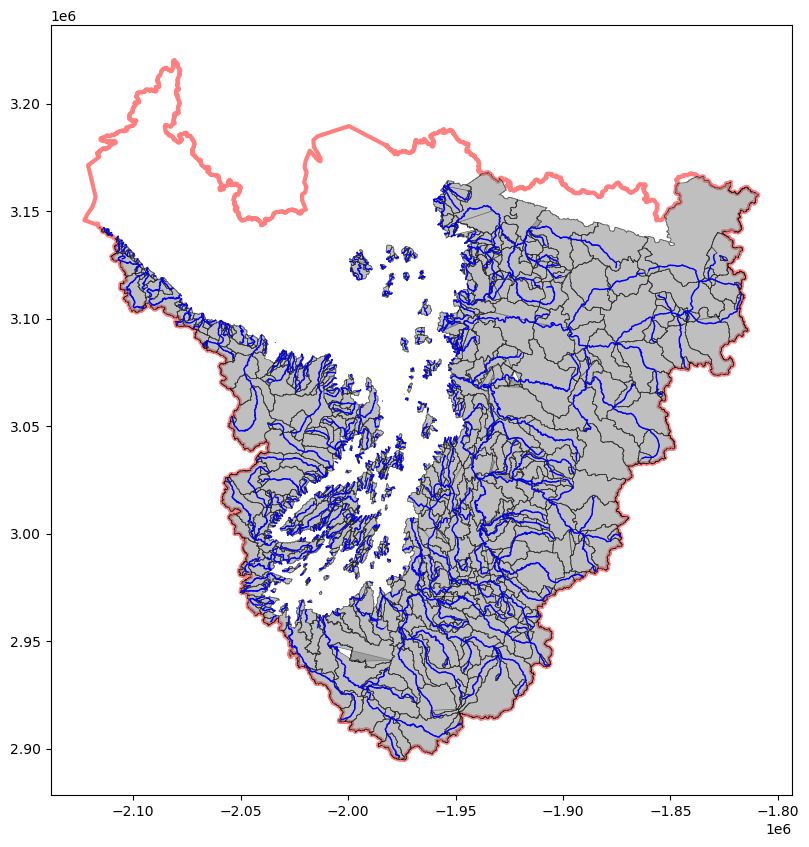

In [75]:
# plot the features enclosed within the HUC6 polygon

fig, ax = plt.subplots(figsize=(10, 10))

puget_segments.plot(ax=ax, color="blue", linewidth=1, zorder=2)
puget_watersheds.plot(
    ax=ax, facecolor="gray", edgecolor="black", linewidth=0.5, alpha=0.5, zorder=1
)
puget_huc6.plot(
    ax=ax, facecolor="none", edgecolor="red", linewidth=3, alpha=0.5, zorder=0
)

In [76]:
# you can see some weird geometric artifacts in the watershed polygons...
# this is why they require validation inside of the function!
# probably artifacts of the raster > vector conversion process, or perhaps shapefile > geopackage conversion?

In [77]:
# we can then use these IDs to query the stream flow data from the datacube on rasdaman
print(puget_segments["seg_id_nat"])
print(puget_watersheds["hru_id_nat"])

732     51650
730     51648
563     51481
725     51643
727     51645
        ...  
1309    53374
1266    53331
1272    53337
1268    53333
1310    53375
Name: seg_id_nat, Length: 945, dtype: int64
178     100297
238     100374
215     100345
360     100521
236     100372
         ...  
1822    102237
1824    102239
1857    102272
1894    102309
1939    102356
Name: hru_id_nat, Length: 1842, dtype: int64


In [ ]:
# test of stream segments coverage
# set the request parameters
coverage_id = "conus_hydro_segments_crstephenson"
var = "dh3"
lc = "dynamic"
model = "CCSM4"
scenario = "historical"
era = "1976_2005"

# and get stream segments within the puget sound HUC6
# stream_ids = ",".join(puget_segments["seg_id_nat"].astype(str).values)
# ^^^ this results in a very long URL, which works, but is probably not a good idea..
# Let's just get all segments at once for this data fetch demo.

In [ ]:
request_string = f"https://zeus.snap.uaf.edu/rasdaman/ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST=GetCoverage&"
request_string += f"COVERAGEID={coverage_id}&"
request_string += f"SUBSET=lc({encodings_lookup['lc'][lc]})&"
request_string += f"SUBSET=model({encodings_lookup['model'][model]})&"
request_string += f"SUBSET=scenario({encodings_lookup['scenario'][scenario]})&"
request_string += f"SUBSET=era({encodings_lookup['era'][era]})&"
# request_string += f"SUBSET=stream_id({stream_ids})&"
request_string += f"RANGESUBSET={var}&"
request_string += f"FORMAT=application/netcdf"

In [ ]:
request_string  # gets all stream_ids for the parameters above

'https://zeus.snap.uaf.edu/rasdaman/ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST=GetCoverage&COVERAGEID=conus_hydro_segments_crstephenson&SUBSET=lc(0)&SUBSET=model(3)&SUBSET=scenario(0)&SUBSET=era(0)&RANGESUBSET=dh3&FORMAT=application/netcdf'

In [81]:
r = requests.get(request_string)
ds = xr.open_dataset(
    io.BytesIO(r.content),
)

In [82]:
ds

<xarray.Dataset> Size: 903kB
Dimensions:  (geom_id: 56460)
Coordinates:
  * geom_id  (geom_id) float64 452kB 1.0 2.0 3.0 ... 5.646e+04 5.646e+04
Data variables:
    dh3      (geom_id) float64 452kB ...
Attributes:
    Encoding:              {'dh3': 'cfs', 'dh15': 'days/year', 'dl3': 'cfs', ...
    Title:                 Hydrological Summary Statistics for CONUS Stream S...
    fileReferenceHistory:  /opt/rasdaman-storage/user_data/crstephenson/hydro...

In [ ]:
# grab the data for just puget sound stream_ids
puget_stream_ids = puget_segments["seg_id_nat"].astype(float).values
puget_ds = ds.sel(stream_id=puget_stream_ids)

In [ ]:
puget_df = pd.DataFrame(
    data={"stream_id": puget_ds["stream_id"], var: puget_ds[var].values}
)

In [ ]:
# convert back to int so we can join and plot
puget_df["stream_id"] = puget_df["stream_id"].astype(int)
puget_df

,geom_id,dh3
0,51650,162.4400
1,51648,87.1470
2,51481,270.0200
3,51643,154.6800
4,51645,13.8150
...,...,...
940,53374,8.9487
941,53331,260.2100
942,53337,NaN
943,53333,328.0200


In [ ]:
# join to the puget gdf
puget_segments = puget_segments.merge(
    puget_df, left_on="seg_id_nat", right_on="stream_id"
)

In [87]:
puget_segments

,geometry,region,seg_id_nat,POI_ID,GNIS_NAME,geom_id,dh3
0,"LINESTRING (-2035954.043 2958938.439, -2035951...",17,51650,23990741,McLane Creek,51650,162.4400
1,"LINESTRING (-2038593.592 2966305.130, -2038576...",17,51648,23990725,Perry Creek,51648,87.1470
2,"LINESTRING (-2039527.856 2967609.618, -2039529...",17,51481,23989357,Kennedy Creek,51481,270.0200
3,"LINESTRING (-2038681.121 2967187.414, -2038604...",17,51643,23990691,Schneider Creek,51643,154.6800
4,"LINESTRING (-2040586.409 2968248.750, -2040653...",17,51645,23990701,,51645,13.8150
...,...,...,...,...,...,...,...
940,"LINESTRING (-1955218.479 3158517.352, -1955329...",17,53374,24535032,,53374,8.9487
941,"LINESTRING (-1955263.268 3159862.954, -1955273...",17,53331,24534530,California Creek,53331,260.2100
942,"LINESTRING (-1954093.283 3160552.402, -1954220...",17,53337,24534648,,53337,NaN
943,"LINESTRING (-1953773.114 3161553.059, -1953910...",17,53333,24534568,Dakota Creek,53333,328.0200


/var/folders/dz/1ccfqg_n5mg3fsrt8rwm7fd80000gn/T/ipykernel_2449/2100101869.py:5: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  puget_segments.plot(ax=ax, column=var, colormap="viridis", linewidth=1, zorder=2)


<Axes: >

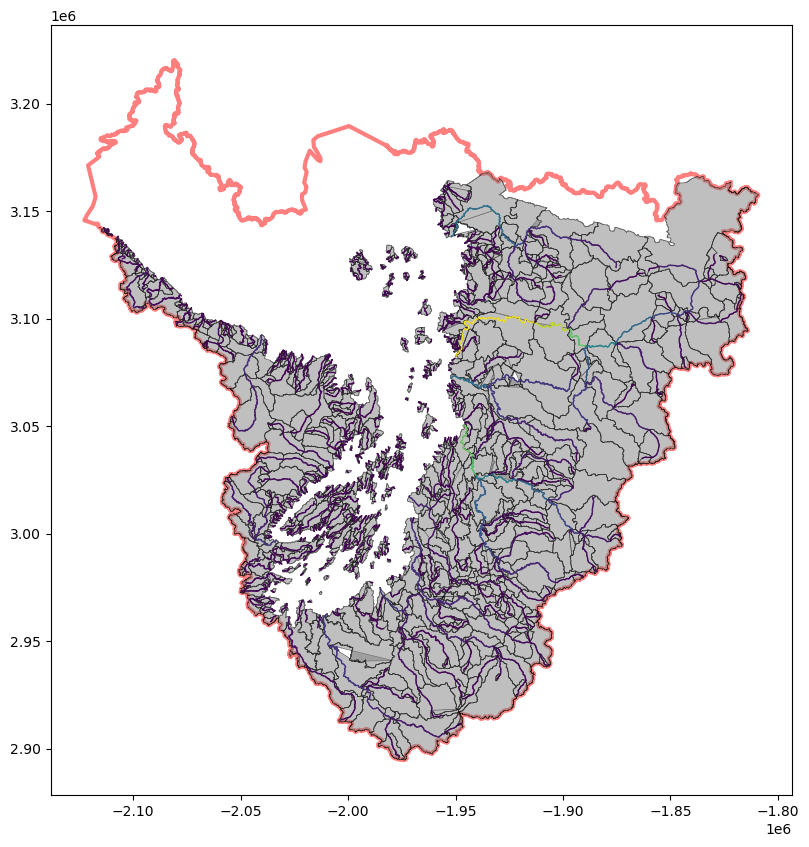

In [88]:
# plot the features enclosed within the HUC6 polygon, lighting up stream segments with flow data

fig, ax = plt.subplots(figsize=(10, 10))

puget_segments.plot(ax=ax, column=var, colormap="viridis", linewidth=1, zorder=2)
puget_watersheds.plot(
    ax=ax, facecolor="gray", edgecolor="black", linewidth=0.5, alpha=0.5, zorder=1
)
puget_huc6.plot(
    ax=ax, facecolor="none", edgecolor="red", linewidth=3, alpha=0.5, zorder=0
)

In [90]:
# here is what what an API response could potentially look like

# start with the skeleton and fill in with what data we have
huc6_dict = {
    "name": huc6_name,
    "huc6": huc6_id,
    "data": {
        "watershed_data": {},
        "segment_data": {},
        "features": {
            "watershed_geometry": {},
            "segment_geometry": {},
        },
    },
}

In [91]:
segment_data_dict = {}
segment_feature_dict = {}

for index, row in puget_segments.iterrows():
    segment_data_dict[row["seg_id_nat"]] = {
        "landcover": lc,
        "model": model,
        "scenario": scenario,
        "era": era,
        "stat": {var: row[var]},
    }

    segment_feature_dict[row["seg_id_nat"]] = puget_segments.iloc[[index]][
        ["geometry", "GNIS_NAME"]
    ].to_json()

In [92]:
huc6_dict["data"]["segment_data"] = segment_data_dict
huc6_dict["data"]["features"]["segment_geometry"] = segment_feature_dict

In [93]:
huc6_dict
# missing watershed data for now, and could easily have >1 stat variable and/or >1 model/scenario/era combo if reorganized

{'name': 'Puget Sound',
 'huc6': '171100',
 'data': {'watershed_data': {},
  'segment_data': {51650: {'landcover': 'dynamic',
    'model': 'CCSM4',
    'scenario': 'historical',
    'era': '1976_2005',
    'stat': {'dh3': 162.44}},
   51648: {'landcover': 'dynamic',
    'model': 'CCSM4',
    'scenario': 'historical',
    'era': '1976_2005',
    'stat': {'dh3': 87.147}},
   51481: {'landcover': 'dynamic',
    'model': 'CCSM4',
    'scenario': 'historical',
    'era': '1976_2005',
    'stat': {'dh3': 270.02}},
   51643: {'landcover': 'dynamic',
    'model': 'CCSM4',
    'scenario': 'historical',
    'era': '1976_2005',
    'stat': {'dh3': 154.68}},
   51645: {'landcover': 'dynamic',
    'model': 'CCSM4',
    'scenario': 'historical',
    'era': '1976_2005',
    'stat': {'dh3': 13.815}},
   51480: {'landcover': 'dynamic',
    'model': 'CCSM4',
    'scenario': 'historical',
    'era': '1976_2005',
    'stat': {'dh3': 322.25}},
   51639: {'landcover': 'dynamic',
    'model': 'CCSM4',
    's